# 该代码实现利用人脸的五点仿射变换实现人脸对齐
# 具体就是首先使用mtcnn检测算法检测出人脸区域，并得到lanmarks关键点坐标和检测框坐标之后对人脸区域外扩60%，然后对该外扩后的区域重新得到关键点，进行五点仿射变换得到即可。
# 参考链接：https://blog.csdn.net/oTengYue/article/details/79278572

In [2]:
#基本的引入，按字母表排序
import cv2
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from numpy import random
from numpy.random import uniform
import os
from os import path as osp
import PIL
from PIL import Image, ImageDraw
import random
from random import shuffle
import sys
sys.path.append(r'py')
import time
#torch部分的import
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
#from tensorboardX import SummaryWriter
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
from MTCNN_detector import MtcnnDetector,vis_face

# MTCNN  model

In [6]:
class P_Net(nn.Module):
    def __init__(self):
        super(P_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            # 12x12x3
            nn.Conv2d(3, 10, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # PReLU1
            # 10x10x10
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool1
            # 5x5x10
            nn.Conv2d(10, 16, kernel_size=3, stride=1),  # conv2
            # 3x3x16
            nn.PReLU(),  # PReLU2
            nn.Conv2d(16, 32, kernel_size=3, stride=1),  # conv3
            # 1x1x32
            nn.PReLU()  # PReLU3
        )
        # detection
        self.conv4_1 = nn.Conv2d(32, 1, kernel_size=1, stride=1)
        # bounding box regresion
        self.conv4_2 = nn.Conv2d(32, 4, kernel_size=1, stride=1)
        # landmark localization
        self.conv4_3 = nn.Conv2d(32, 10, kernel_size=1, stride=1)
        # weight initiation with xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        det = torch.sigmoid(self.conv4_1(x))
        box = self.conv4_2(x)
        #landmark = self.conv4_3(x)
        # det:[,2,1,1], box:[,4,1,1], landmark:[,10,1,1]
        return det, box#, landmark


In [7]:
class R_Net(nn.Module):
    def __init__(self):
        super(R_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            # 24x24x3
            nn.Conv2d(3, 28, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            # 22x22x28
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            # 10x10x28
            nn.Conv2d(28, 48, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            # 8x8x48
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            # 3x3x48
            nn.Conv2d(48, 64, kernel_size=2, stride=1),  # conv3
            # 2x2x64
            nn.PReLU()  # prelu3
        )
        # 2x2x64
        self.conv4 = nn.Linear(64 * 2 * 2, 128)  # conv4
        # 128
        self.prelu4 = nn.PReLU()  # prelu4
        # detection
        self.conv5_1 = nn.Linear(128, 1)
        # bounding box regression
        self.conv5_2 = nn.Linear(128, 4)
        # lanbmark localization
        self.conv5_3 = nn.Linear(128, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv4(x)
        x = self.prelu4(x)
        det = torch.sigmoid(self.conv5_1(x))
        #det = F.softmax(self.conv5_1(x), dim=1)#也可以试试softmax呀
        box = self.conv5_2(x)
        #landmark = self.conv5_3(x)
        return det, box#, landmark

In [8]:
class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(),  # prelu3
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool3
            nn.Conv2d(64, 128, kernel_size=2, stride=1),  # conv4
            nn.PReLU()  # prelu4
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5
        # detection
        self.conv6_1 = nn.Linear(256, 1)
        # bounding box regression
        self.conv6_2 = nn.Linear(256, 4)
        # lanbmark localization
        self.conv6_3 = nn.Linear(256, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        # detection
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark


## 相关的一些functions

In [9]:
 # 1. 根据网络层的不同定义不同的初始化方式     
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        #nn.init.constant_(m.bias, 0) bias不要全初始化为0
        nn.init.normal_(m.bias, mean=0, std=1)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
     # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
#使用这样的初始化后，模型的初始表现确实好了些

In [10]:
def load_net(save_folder, net_name):
    # pnet, rnet, onet = P_Net(), R_Net(), O_Net()
    net_list = {'pnet': P_Net(), 'rnet': R_Net(), 'onet': O_Net()}

    try:
        net = net_list[net_name].to(device)
        try:
            print('===> loading the saved net weights...')
            _ = osp.join(save_folder, net_name + '.pkl')
            print('===> check {} saved path({}):{}'.format(net_name, _, osp.exists(_)))
            net.load_state_dict(torch.load(_, map_location=device))
            return net  # , rnet, onet
        except Exception:
            print('*** fail to load the saved net weights!')
            return net
    except Exception:
        print('*** Net name wrong!')

# 利用OpenCV实现仿射人脸

In [48]:
# 最终的人脸对齐图像尺寸分为两种：112x96和112x112，并分别对应结果图像中的两组仿射变换目标点,如下所示
imgSize1 = [112,96]
imgSize2 = [112,112]
coord5point1 = [[30.2946, 51.6963],  # 112x96的目标点
               [65.5318, 51.6963],
               [48.0252, 71.7366],
               [33.5493, 92.3655],
               [62.7299, 92.3655]]
coord5point2 = [[30.2946+8.0000, 51.6963], # 112x112的目标点
               [65.5318+8.0000, 51.6963],
               [48.0252+8.0000, 71.7366],
               [33.5493+8.0000, 92.3655],
               [62.7299+8.0000, 92.3655]]

def transformation_from_points(points1, points2):
    '''0 - 先确定是float数据类型 '''
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    '''1 - 消除平移的影响 '''
    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    '''2 - 消除缩放的影响 '''
    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    '''3 - 计算矩阵M=BA^T；对矩阵M进行SVD分解；计算得到R '''
    U, S, Vt = np.linalg.svd(points1.T * points2)
    R = np.dot(U, Vt)
    '''4 - 构建仿射变换矩阵 '''
    s = s2/s1
    sR = s*R
    c1 = c1.reshape(2,1)
    c2 = c2.reshape(2,1)
    T = c2 - np.dot(sR,c1) # 模板人脸的中心位置减去 需要对齐的中心位置（经过旋转和缩放之后）

    trans_mat = np.hstack([sR,T])   # 2x3

    return trans_mat

def warp_im(img_im, orgi_landmarks,tar_landmarks):
    pts1 = np.float64(np.matrix([[point[0], point[1]] for point in orgi_landmarks]))
    pts2 = np.float64(np.matrix([[point[0], point[1]] for point in tar_landmarks]))
    M = transformation_from_points(pts1, pts2)
    dst = cv2.warpAffine(img_im, M[:2], (img_im.shape[1], img_im.shape[0]),borderMode=cv2.BORDER_TRANSPARENT)
    return dst

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 17)

In [38]:
def opencv_image(image_path):
    #加载mtcnn参数
    save_folder="CHUHR"
    pnet= load_net(save_folder,'pnet')
    rnet= load_net(save_folder,'rnet')
    onet= load_net(save_folder,'onet')
    mtcnn_detector = MtcnnDetector(pnet=pnet,rnet=rnet,onet=onet,min_face_size=12,threshold=[0.1,0.5,0.9])
    img = Image.open(image_path)
    bounding_boxes, points= mtcnn_detector.detect_face(img)
    img_im = cv2.imread(image_path)
    shape = img_im.shape
    height = shape[0]
    width = shape[1]
    # 处理该张图片中的每个框
    if bounding_boxes.shape[0] > 0:
        for i in range(bounding_boxes.shape[0]):  # 根据行号得到每张图片有多少个回归框
            print(i)
            x1, y1, x2, y2 = int(bounding_boxes[i][0]), \
                             int(bounding_boxes[i][1]), \
                             int(bounding_boxes[i][2]), \
                             int(bounding_boxes[i][3])
            # 外扩大100%，防止对齐后人脸出现黑边
            new_x1 = max(int(1.50 * x1 - 0.50 * x2),0)
            new_x2 = min(int(1.50 * x2 - 0.50 * x1),width-1)
            new_y1 = max(int(1.50 * y1 - 0.50 * y2),0)
            new_y2 = min(int(1.50 * y2 - 0.50 * y1),height-1)
            # new_x1 = max(int(1.30 * x1 - 0.30 * x2),0)
            # new_x2 = min(int(1.30 * x2 - 0.30 * x1),width-1)
            # new_y1 = max(int(1.30 * y1 - 0.30 * y2),0)
            # new_y2 = min(int(1.30 * y2 - 0.30 * y1),height-1)
            
            
            landmarks_one = points[i, :]
            points = landmarks_one.reshape((5, 2))
            
            # 得到原始图中关键点坐标
            left_eye_x = points[0][0]
            right_eye_x = points[1][0]
            nose_x = points[2][0]
            left_mouth_x = points[3][0]
            right_mouth_x = points[4][0]
            left_eye_y = points[1][1]
            right_eye_y = points[0][1]
            nose_y = points[2][1]
            left_mouth_y = points[3][1]
            right_mouth_y = points[4][1]

            # 得到外扩100%后图中关键点坐标
            new_left_eye_x = left_eye_x - new_x1
            new_right_eye_x = right_eye_x - new_x1
            new_nose_x = nose_x - new_x1
            new_left_mouth_x = left_mouth_x - new_x1
            new_right_mouth_x = right_mouth_x - new_x1
            new_left_eye_y = left_eye_y - new_y1
            new_right_eye_y = right_eye_y - new_y1
            new_nose_y = nose_y - new_y1
            new_left_mouth_y = left_mouth_y - new_y1
            new_right_mouth_y = right_mouth_y - new_y1

            face_landmarks = [[new_left_eye_x,new_left_eye_y], # 在扩大100%人脸图中关键点坐标
                              [new_right_eye_x,new_right_eye_y],
                              [new_nose_x,new_nose_y],
                              [new_left_mouth_x,new_left_mouth_y],
                              [new_right_mouth_x,new_right_mouth_y]]
            face = img_im[new_y1: new_y2, new_x1: new_x2] # 扩大100%的人脸区域
            dst1 = warp_im(face,face_landmarks,coord5point1) # 112x96对齐后尺寸
            dst2 = warp_im(face,face_landmarks,coord5point2) # 112x112对齐后尺寸
            crop_im1 = dst1[0:imgSize1[0],0:imgSize1[1]]
            crop_im2 = dst2[0:imgSize2[0],0:imgSize2[1]]
            cv2.imwrite(image_path + str(i)+'_align_112x96.jpg',crop_im1)
            cv2.imwrite(image_path+ str(i)+'_align_112x112.jpg',crop_im2)


In [39]:
def extract_image_chips1( image_path,  desired_size=256, padding=0):
    """
        crop and align face
    Parameters:
    ----------
        img: numpy array, input image
        points: numpy array, n x 10 (x1, x2 ... x5, y1, y2 ..y5)
        desired_size: default 256
        padding: default 0
    Retures:
    -------
        crop_imgs: list, n
            cropped and aligned faces
    """
    #加载mtcnn参数
    save_folder="CHUHR"
    pnet= load_net(save_folder,'pnet')
    rnet= load_net(save_folder,'rnet')
    onet= load_net(save_folder,'onet')
    mtcnn_detector = MtcnnDetector(pnet=pnet,rnet=rnet,onet=onet,min_face_size=12,threshold=[0.1,0.5,0.9])
    img = Image.open(image_path)
    bounding_boxes, points= mtcnn_detector.detect_face(img)
    img = cv2.imread(image_path)
    
    crop_imgs = []
    for ind,p in enumerate(points):
        # 当前图片中一共有len(points)个人脸
        shape  =[]
        for k in range(len(p)//2):
            shape.append(p[k])
            shape.append(p[k+5])

        if padding > 0:
            padding = padding
        else:
            padding = 0
        # 平均脸（模板脸）的5个关键点坐标
        mean_face_shape_x = [0.224152, 0.75610125, 0.490127, 0.254149, 0.726104]
        mean_face_shape_y = [0.2119465, 0.2119465, 0.628106, 0.780233, 0.780233]

        from_points = []
        to_points = []

        for i in range(len(shape)//2):
            x = (padding + mean_face_shape_x[i]) / (2 * padding + 1) * desired_size
            y = (padding + mean_face_shape_y[i]) / (2 * padding + 1) * desired_size
            to_points.append([x, y])
            from_points.append([shape[2*i], shape[2*i+1]])

        # 构建人脸关键点矩阵
        from_mat = np.asarray(from_points)
        to_mat = np.asarray(to_points)

        # 计算from_mat映射到to_mat的仿射变换矩阵，是一个2x3的矩阵
        trans_mat = transformation_from_points(from_mat,to_mat)
        print(trans_mat)
        # 进行仿射变换，并取当前中心向外(desired_size,desired_size)大小的区域
        dst_size = (desired_size,desired_size)
        chips = warp_im(img, trans_mat, dst_size)

        crop_imgs.append(chips)

    return crop_imgs


In [40]:
opencv_image("beauty/beauty2.jpg")

===> loading the saved net weights...
===> check pnet saved path(CHUHR/pnet.pkl):True
===> loading the saved net weights...
===> check rnet saved path(CHUHR/rnet.pkl):True
===> loading the saved net weights...
===> check onet saved path(CHUHR/onet.pkl):True
time cost 0.404  pnet 0.222  rnet 0.155  onet 0.027
0
[[167.7920338511467, 130.8544818162918], [211.60425066947937, 120.7518145442009], [176.85917884111404, 150.9690033197403], [161.51363521814346, 171.38488191366196], [198.12801003456116, 181.19802749156952]]


In [20]:
opencv_image("CHR_images/CHR7.jpg")

===> loading the saved net weights...
===> check pnet saved path(CHUHR/pnet.pkl):True
===> loading the saved net weights...
===> check rnet saved path(CHUHR/rnet.pkl):True
===> loading the saved net weights...
===> check onet saved path(CHUHR/onet.pkl):True
time cost 4.750  pnet 4.620  rnet 0.120  onet 0.009
0
[[433.244677066803, 778.6873925924301], [600.5170275568962, 707.8392439931631], [472.00807946920395, 840.1459328532219], [376.1565704345703, 889.2558063268661], [521.4526629447937, 952.8410559892654]]


In [32]:
def test_image(image_path,save_name):
    #加载mtcnn参数
    save_folder="CHUHR"
    pnet= load_net(save_folder,'pnet')
    rnet= load_net(save_folder,'rnet')
    onet= load_net(save_folder,'onet')
    mtcnn_detector = MtcnnDetector(pnet=pnet,rnet=rnet,onet=onet,min_face_size=12,threshold=[0.1,0.5,0.9])
    img = Image.open(image_path)
    bboxs, landmarks = mtcnn_detector.detect_face(img)
    print(bboxs)
    # print box_align and landmarks
    vis_face(img,bboxs,landmarks, save_name)

===> loading the saved net weights...
===> check pnet saved path(CHUHR/pnet.pkl):True
===> loading the saved net weights...
===> check rnet saved path(CHUHR/rnet.pkl):True
===> loading the saved net weights...
===> check onet saved path(CHUHR/onet.pkl):True
time cost 0.420  pnet 0.186  rnet 0.191  onet 0.043
[[176.51254891  58.75333762 310.78354008 242.45243023   0.99412894]]


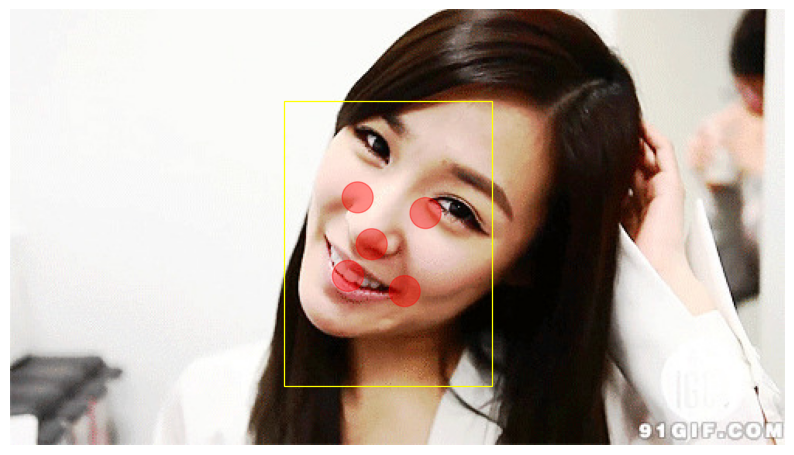

In [37]:
test_image("beauty/beauty2.jpg","beauty/beauty2_try_7.png")

===> loading the saved net weights...
===> check pnet saved path(CHUHR/pnet.pkl):True
===> loading the saved net weights...
===> check rnet saved path(CHUHR/rnet.pkl):True
===> loading the saved net weights...
===> check onet saved path(CHUHR/onet.pkl):True
time cost 0.815  pnet 0.763  rnet 0.033  onet 0.019
[[ 433.24467707  845.83924399  600.51702756  916.68739259  472.00807947
   978.14593285  376.15655413 1027.25580633  521.45266294 1090.84105599]]


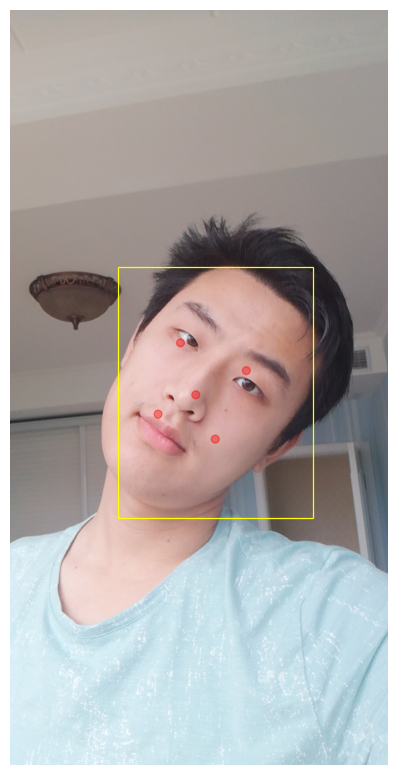

In [27]:
test_image("CHR_images/CHR7.jpg","CHR_images/CHR_try_7.png")

In [ ]:
def warp_affine(image, points, scale=1.0):
        eye_center = ((points[0][0] + points[1][0]) / 2, (points[0][1] + points[1][1]) / 2)
        dy = points[1][1] - points[0][1]
        dx = points[1][0] - points[0][0]
        # 计算旋转角度
        angle = cv2.fastAtan2(dy, dx)
        rot = cv2.getRotationMatrix2D(eye_center, angle, scale=scale)
        rot_img = cv2.warpAffine(image, rot, dsize=(image.shape[1], image.shape[0]))
        plt.imshow(rot_img)
        plt.show()
        return rot_img

作者：孙宇辉
链接：https://www.zhihu.com/question/274001027/answer/374213141
来源：知乎
著作权归作者所有。商业转载请联系作者获得授权，非商业转载请注明出处。